In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/whats-cooking/test.json.zip
/kaggle/input/whats-cooking/train.json.zip
/kaggle/input/whats-cooking/sample_submission.csv.zip


In [2]:
import matplotlib.pyplot as plt
import zipfile

In [3]:
zip_train = zipfile.ZipFile('../input/whats-cooking/train.json.zip')
zip_test = zipfile.ZipFile('../input/whats-cooking/test.json.zip')
data_train = pd.read_json(zip_train.read("train.json"))
data_test = pd.read_json(zip_test.read("test.json"))

In [4]:
data_train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [5]:
data_test.tail()

,id,ingredients
9939,30246,"[large egg yolks, fresh lemon juice, sugar, bo..."
9940,36028,"[hot sauce, butter, sweet potatoes, adobo sauc..."
9941,22339,"[black pepper, salt, parmigiano reggiano chees..."
9942,42525,"[cheddar cheese, cayenne, paprika, plum tomato..."
9943,1443,"[cold water, olive oil, lime wedges, garlic cl..."


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB


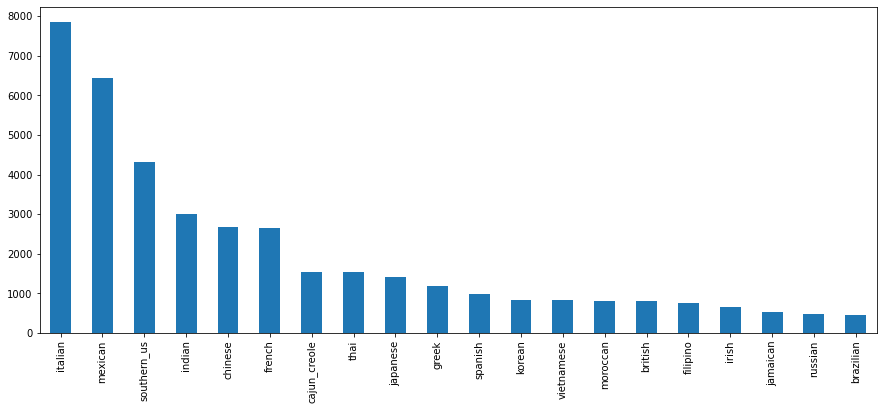

In [8]:
plt.figure(figsize = (15,6))
data_train["cuisine"].value_counts().plot.bar()

In [9]:
data_train["ingredient_string"] = data_train["ingredients"].map(lambda x: " ".join([a.replace(' ','_') for a in x]))
data_test["ingredient_string"] = data_test["ingredients"].map(lambda x: " ".join([a.replace(' ','_') for a in x]))
data_train.head()

,id,cuisine,ingredients,ingredient_string
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine_lettuce black_olives grape_tomatoes ga...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain_flour ground_pepper salt tomatoes ground...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking_oil green_c...
3,22213,indian,"[water, vegetable oil, wheat, salt]",water vegetable_oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",black_pepper shallots cornflour cayenne_pepper...


In [10]:
data_test.tail()

,id,ingredients,ingredient_string
9939,30246,"[large egg yolks, fresh lemon juice, sugar, bo...",large_egg_yolks fresh_lemon_juice sugar bourbo...
9940,36028,"[hot sauce, butter, sweet potatoes, adobo sauc...",hot_sauce butter sweet_potatoes adobo_sauce salt
9941,22339,"[black pepper, salt, parmigiano reggiano chees...",black_pepper salt parmigiano_reggiano_cheese r...
9942,42525,"[cheddar cheese, cayenne, paprika, plum tomato...",cheddar_cheese cayenne paprika plum_tomatoes g...
9943,1443,"[cold water, olive oil, lime wedges, garlic cl...",cold_water olive_oil lime_wedges garlic_cloves...


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_data = vectorizer.fit_transform(data_train["ingredient_string"])
vectorizer.get_feature_names()[:20]

['10_oz',
 '14',
 '14_oz',
 '15_oz',
 '25',
 '2_1',
 '2_to_3_lb',
 '33',
 '40',
 '5_oz',
 '7_up',
 '8_ounc_ziti_pasta',
 '95',
 '_1_inch_thick',
 '____oz',
 '___oz',
 '_alfredo',
 '_alfredo_sauce',
 '_all_purpose_sticks',
 '_arrabbiata_sauce']

In [12]:
print(X_data.shape, data_train.shape)

(39774, 6867) (39774, 4)


In [13]:
y_data = data_train["cuisine"]

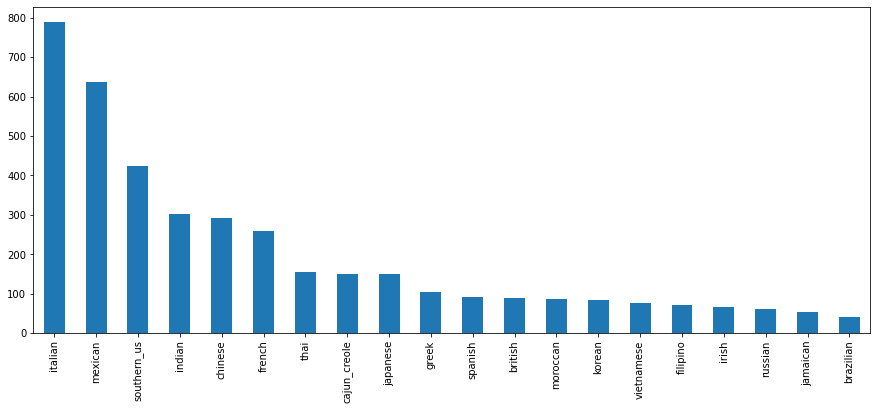

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size = 0.1)

plt.figure(figsize = (15,6))
y_valid.value_counts().plot.bar()

In [15]:
X_test = vectorizer.transform(data_test["ingredient_string"])

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model_1 = XGBClassifier(n_estimators = 3000, objective='multi:softmax')
model_1.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 5, verbose = False)
predict_1 = model_1.predict(X_valid)
score = accuracy_score(y_valid, predict_1)
score

0.7521367521367521

In [17]:
predict = model_1.predict(X_test)

In [18]:
len(predict)

9944

In [19]:
subm = data_test[["id"]].copy()
subm["cuisine"] = predict
subm.head()

,id,cuisine
0,18009,british
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian


In [20]:
subm.tail()

,id,cuisine
9939,30246,french
9940,36028,southern_us
9941,22339,italian
9942,42525,southern_us
9943,1443,mexican


In [21]:
subm.to_csv("./submissio3.csv", index = False)